# A gentle intrudction to neurolib
> A Python framework for easy whole-brain modeling

- comments: true
- author: Caglar Cakan
- categories: [neurolib, introduction]
- permalink: /neurolib-intro/
- image: images/icon_frame.png
- license: Creative Commons

<p align="center">
  <img src="https://raw.githubusercontent.com/caglorithm/notebooks/master/images/icon_frame.png" width="400">
</p>

# What is neurolib?

In its essence, `neurolib` is a computational framework for simulating coupled neural mass models. Neural mass models are mathematical models that help to simulate and understand the behaviour of large number of (coupled) neurons. Typically, these models make use of the statistical insight that the collective, macroscopic behavior of a large network of randomly connected neurons can be described without having to know the exact dynamics of every individual neuron at every time step. This is much like a statistical physicist would treat a gas where for example the temperature of the gas is an expression of the mean velocity of the gas particles, not the individual velocity of each particle.

> Now that we know what neural masses are, what are they useful for and how is this related to `neurolib`? 

One of the applications of neural mass models in computational neuroscience is in whole-brain modeling, where a coarse-grained simulation of the activity of a large network of brain areas is achieved by combining simulations of neural masses with structural connectivity scans (often reffered to as the connectome) of the human brain which captures large axonal connections that connect distant brain areas.

`neurolib` allows you to build, simulate, and optimize your own state-of-the-art whole-brain models. To simulate the neural activity of each brain area, the main implementation provides an advanced neural mass mean-field model of spiking adaptive exponential integrate-and-fire neurons (AdEx) called `aln`. Each brain area is represented by two populations of excitatory and inhibitory neurons. An extensive analysis and validation of the aln model can be found in our paper [1].

[1] Cakan et al. (2020). Biophysically grounded mean-field models of neural populations under electrical stimulation. PLOS Computational Biology ([ArXiv](https://arxiv.org/abs/1906.00676)).

The figure below shows a schematic of how a brain network can be constructed:

<p align="center">
  <img src="https://github.com/neurolib-dev/neurolib/raw/master/resources/pipeline.png" width="700">
</p>

# The neural mass model

In this notebook we will learn about the basics of `neurolib`. We will create a two-population mean-field model of exponential integrate-and-fire neurons called the `aln` model. We will learn how to create a `Model`, set some parameters and run a simulation. We will also see how we can easily access the output of each simulation.

## aln - the adaptive linear-nonlinear cascade model

The adaptive linear-nonlinear (`aln`) cascade model is a low-dimensional population model of spiking neural networks. Mathematically, it is a dynamical system of non-linear ODEs. The dynamical variables of the system simulated in the `aln` model describe the average firing rate and other **macroscopic variables** of a randomly connected, delay-coupled network of excitatory and inhibitory **adative exponential integrate-and-fire neurons (AdEx)** with non-linear synaptic currents. 

Ultimately, the model is a result of various steps of model reduction starting from the Fokker-Planck equation of the AdEx neuron subject to white noise input at many steps of input means $\mu$ and variances $\sigma$. The resulting mean firing rates and mean membrane potentials are then stored in a lookup table and serve as the nonlinear firing rate transfer function, $r = \Phi(\mu, \sigma)$. 

# Using neurolib

Let's get going after all this reading. `neurolib` makes it easy to set of your simulation. Below, we demonstrate how you set up a model and interact with its paramters. We will first explore the a single node and get comfortable with the way things work and then set up a whole-brain simulation and simulate fMRI activity.

In [1]:
#hide
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt
    
import numpy as np
import scipy

# Some useful functions are provided here
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

In [2]:
import matplotlib.pyplot as plt
plt.style.use('dark')

## Simulating a single node

To create a single node, we  instanciate the model without any arguments. 

In [3]:
# Let's import the aln model
from neurolib.models.aln import ALNModel

# Create the model
aln = ALNModel()

# Each model comes with a set of default parameters which are are a dictionary. 
# Let's change the parameter that controls the duration of a simulation to 10s.
aln.params['duration'] = 10.0 * 1000  

# For convenience, we could also use:
aln.params.duration = 10.0 * 1000

# In the aln model an Ornstein-Uhlenbeck process is simulated in parallel
# as the source of input noise fluctuations. Here we can set the variance
# of the process. 
# For more info: https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process 
# Let's add some noise.
aln.params['sigma_ou'] = 0.1

# Finally, we run the model
aln.run()

### Accessing the outputs

Accessing the outputs is straight-forward. Every model's outputs
are stored in the `model.outputs` attribute. According to the specific
name of each of the model's outputs, they can also be accessed as a 
key of the Model object, i.e. `aln['rates_exc']`.

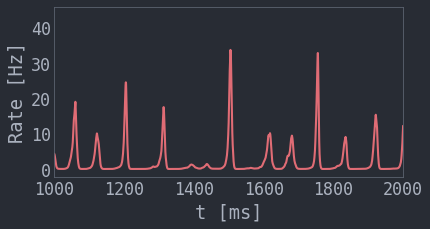

In [4]:
plt.figure(figsize=(6, 3), dpi=75)
plt.plot(aln['t'], aln['rates_exc'].T, lw=2)
plt.xlabel("t [ms]")
plt.ylabel("Rate [Hz]")
plt.xlim(1000, 2000);

In [5]:
# Outputs are also available as an xr DataArray
xr = aln.xr()
print(xr.dims)
# outputs can also be accessed via attributes in dot.notation
print("rates_exc", aln.rates_exc)

('output', 'space', 'time')
rates_exc [[26.15770656 24.06801404 22.22713507 ...  1.82543728  1.78704101
   1.75078031]]


## Whole-brain modeling

Typically, in whole-brain modeling, diffusion tensor imaging (DTI) is used to infer the structural connectivity (the connection strength) between different brain areas. In a DTI scan, the direction of the diffusion of molecules is measured across the whole brain. Using [tractography](https://en.wikipedia.org/wiki/Tractography), this information can yield the distribution of axonal fibers in the brain that connect distant brain areas, called the connectome. Together with an atlas that divides the brain into distinct areas, a matrix can be computed that encodes how many fibers go from one area to another, the so-called structural connectivity (SC) matrix. This matrix defines the coupling strengths between brain areas and acts as an adjacency matrix of the brain network. The length of the fibers determine the signal transmission delay between all brain areas. When the structural data is combined with a computational model of the neuronal activity of the cortex, we can create a dynamical model of the whole brain.

The resulting whole-brain model consists of interconnected brain areas, with each brain area having their internal neural dynamics. The neural activity is used to simulate hemodynamic [BOLD](https://en.wikipedia.org/wiki/Blood-oxygen-level-dependent_imaging) activity using the Balloon-Windkessel model, which can be compared to empirical fMRI data. The simulated BOLD activity is used to compute correlations of activity between all brain areas, the so called [resting state functional connectivity](https://en.wikipedia.org/wiki/Resting_state_fMRI#Functional), which can then be fitted to empirical fMRI resting-state data.

## Setting up a brain

`neurolib` comes with some example datasets for exploring its functionality. Please be aware that these datasets are not tested and should not be used for your research, only for experimentation with the software.

A dataset for whole-brain modeling can consists of the following parts:

* A structural connectivity matrix capturing the synaptic connection strengths between brain areas, often derived from DTI tractography of the whole brain. The connectome is then typically parcellated in a preferred atlas (for exapmle the AAL2 atlas) and the number of axonal fibers connecting each brain area with every other area is counted. This number serves as a indication of the synaptic coupling strengths between the areas of the brain. 
* A delay matrix which can be calculated from the average length of the axonal fibers connecting each brain area with another.
* A set of functional data that can act as a target for model optimization. Resting-state fMRI offers an easy and fairly unbiased way for calibrating whole-brain models. EEG data could be used as well.

We can load a `Dataset` by passing the name of it in the constructor. 

In [6]:
from neurolib.utils.loadData import Dataset
ds = Dataset("hcp")

We now create the `aln` model with a structural connectivity matrix and a delay matrix. In order to achieve a good fit of the BOLD activity to the empirical data, the model has to run for quite a while. A a rule of thumb, a simulation of resting-state BOLD activity should not be shorter than 3 minutes and preferrably longer than 5 minutes real time. If the empirical recordings are for example 10 minues long, ideally, a simulation of 10 minutes would be used to compare the output of the model to the resting state recording.

In [7]:
aln = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat)

# Let's run the simulation for 1 minute
aln.params['duration'] = 1*60*1000 

After some optimization to the resting-state fMRI data of the dataset, we 
found a set of parameters that creates interesting whole-brain dynamics. 
We set the mean input of the excitatory and the inhibitory population to be 
close to the E-I limit cycle.

In [8]:
aln.params['mue_ext_mean'] = 1.57
aln.params['mui_ext_mean'] = 1.6
# We set an appropriate level of noise
aln.params['sigma_ou'] = 0.09
# And turn on adaptation with a low value of spike-triggered adaptation currents.
aln.params['b'] = 5.0

Let's have a look what the data looks like. We can access the
data of each model by calling its internal attrivbutes.
Here, we plot the structural connectivity matrix by calling 
`aln.params['Cmat']` and fiber length matrix by calling 
`aln.params['lengthMat']`.
Of course, we can also access the dataset using the `Dataset`
object itself. For example the functional conencity matrices 
of the BOLD timeseries in the datasets are given as list with 
`ds.FCs`.

Text(0, 0.5, 'Brain area')

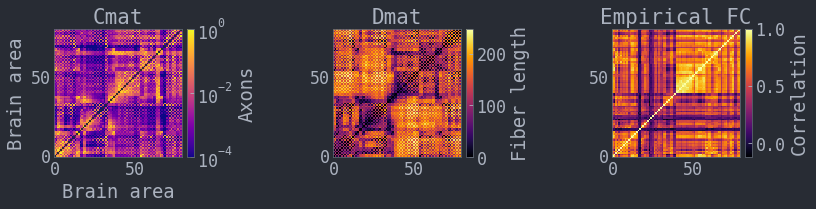

In [9]:
#hide_input
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1, 3, figsize=(12,8), dpi=75)
fig.subplots_adjust(wspace=1)

im = axs[0].imshow(aln.params['Cmat'], norm=LogNorm(vmin=10e-5, vmax=np.max(aln.params['Cmat'])))
axs[0].set_title("Cmat")
fig.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04, label='Axons')
im = axs[1].imshow(aln.params['lengthMat'], cmap='inferno')
axs[1].set_title("Dmat")
fig.colorbar(im, ax=axs[1],fraction=0.046, pad=0.04, label='Fiber length')
im = axs[2].imshow(ds.FCs[0], cmap='inferno')
axs[2].set_title("Empirical FC")
fig.colorbar(im, ax=axs[2],fraction=0.046, pad=0.04, label='Correlation')

axs[0].set_xlabel("Brain area")
axs[0].set_ylabel("Brain area")

## Run model

We run the model with bold simulation by using `bold=True`. 
This simulates the Balloon-Windkessel BOLD model in parallel to
the neural population model in order to estimate the blood oxigen
levels of the underlying neural activity. The output of the `bold`
model can be used to compare the simulated data to empirical fMRI 
data (resting-state fMRI for example).

To save (a lot of) RAM, we can run the simulation in `chunkwise` mode.
In this mode, the model will be simulated for a length of `chunksize` 
steps (not time in ms, but actual integration steps!), and the output
of that chunk will be used to automatically reinitiate the model with 
the appropriate initial conditions. This allows for a serial continuation
of the model without having to store all the data in memory and is 
particularly useful for very long and many parallel simulations.

In [10]:
aln.run(chunkwise=True, chunksize = 100000, bold=True)

## Results

The outputs of the model can be accessed using the attribute `model.outputs`

In [11]:
aln.outputs.keys()

dict_keys(['t', 'rates_exc', 'rates_inh', 'BOLD'])

For convenience, they can also be accessed directly using attributes of the model with the outputs name, like `aln.rates_exc`. The outputs are also available as xr DataArrays as `aln.xr()`.

The since we used `bold=True` to simulate BOLD, we can also access `aln.BOLD.BOLD` for the actual BOLD activity, and `aln.BOLD.t` for the time steps of the BOLD simulation (which are downsampled to `0.5 Hz` by default).

### Plot simulated activity

Text(0, 0.5, 'Brain area')

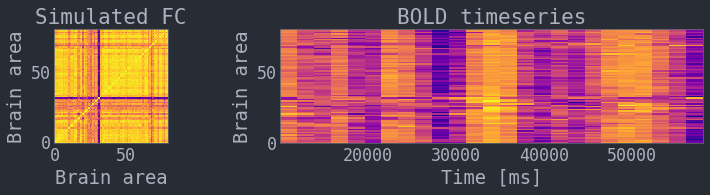

In [12]:
#hide_input
# Plot functional connectivity and BOLD timeseries (z-scored)
fig, axs = plt.subplots(1, 2, figsize=(12, 2), dpi=75, gridspec_kw={'width_ratios' : [1, 2]})
axs[0].imshow(func.fc(aln.BOLD.BOLD[:, 5:]))
axs[1].imshow(scipy.stats.mstats.zscore(aln.BOLD.BOLD[:, aln.BOLD.t_BOLD>10000], axis=1), aspect='auto', extent=[aln.BOLD.t_BOLD[aln.BOLD.t_BOLD>10000][0], aln.BOLD.t_BOLD[-1], 0, aln.params['N']]);

axs[0].set_title("Simulated FC")
axs[0].set_xlabel("Brain area")
axs[0].set_ylabel("Brain area")

axs[1].set_title("BOLD timeseries")
axs[1].set_xlabel("Time [ms]")
axs[1].set_ylabel("Brain area")

Text(0, 0.5, 'Firing rate [Hz]')

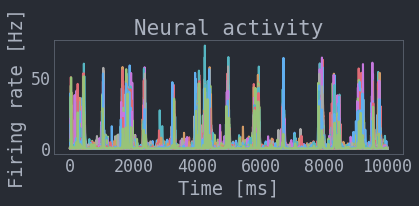

In [13]:
# the results of the model are also accesible through an xarray DataArray
fig, axs = plt.subplots(1, 1, figsize=(6, 2), dpi=75)
axs.plot(aln.xr().time, aln.xr().loc['rates_exc'].T);
axs.set_title("Neural activity")
axs.set_xlabel("Time [ms]")
axs.set_ylabel("Firing rate [Hz]")

### Correlation of simulated BOLD to empirical data

We can compute the element-wise Pearson correlation of the functional connectivity matrices of the simulated data to the empirical data to estimate how well the model captures the inter-areal BOLD correlations found in empirical resting-state recordings. 

In [14]:
scores = [func.matrix_correlation(func.fc(aln.BOLD.BOLD[:, 5:]), fcemp) for fcemp in ds.FCs]

print("Correlation per subject:", [f"{s:.2}" for s in scores])
print(f"Mean FC/FC correlation: {np.mean(scores):.2}")

Correlation per subject: ['0.42', '0.46', '0.55', '0.37', '0.43', '0.39', '0.54']
Mean FC/FC correlation: 0.45


Since this notebook is automatically generated, I hope the result is pretty good for a 1 minute simulation :)

# Acknowledgments

`neurolib` is built on other amazing open source projects:

* [pypet](https://github.com/SmokinCaterpillar/pypet) - Python parameter exploration toolbox
* [deap](https://github.com/DEAP/deap) - Distributed Evolutionary Algorithms in Python
* [numpy](https://github.com/numpy/numpy) - The fundamental package for scientific computing with Python
* [numba](https://github.com/numba/numba) - NumPy aware dynamic Python compiler using LLVM
* [Jupyter](https://github.com/jupyter/notebook) - Jupyter Interactive Notebook
* [fastpages](https://github.com/fastai/fastpages) - An easy to use blogging platform
* [binder](https://github.com/binder-project/binder) - Reproducible executable environments
* [Bob Holzer](https://thenounproject.com/term/brain-network/100405/) is the author of the the brain network visual asset of this post's title image which is released under the Creative Commons license 

In [15]:
#hide_input
import datetime
print("Last build ", datetime.datetime.now().strftime("%d.%m.%y %H:%M:%S"))

Last build  10.04.20 19:53:29
